In [126]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import shap


In [128]:
# 1. Load the Dataset
df = pd.read_csv('/Users/arsh/Downloads/Loan Approval Categorical Synthetic Dataset.csv')
df.head()


,Unnamed: 0,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob,Loan_Approval
0,0,Fair,Low,Small,Suburban,High School,0.545770,Approved
1,1,Good,Low,Large,Urban,High School,0.582107,Approved
2,2,Good,Low,Medium,Rural,High School,0.646670,Approved
3,3,Fair,Medium,Medium,Urban,High School,0.379236,Disapproved
4,4,Bad,Medium,Medium,Suburban,High School,0.633403,Approved


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [132]:
df = pd.read_csv('Loan Approval Categorical Synthetic Dataset.csv')
df_orig = df.copy()  # this will remain unchanged

In [134]:
df_orig = df_orig.drop(df_orig.columns[[0,-2, -1]], axis=1)

In [136]:
df = df.drop(df.columns[[0, -1]], axis=1)

In [138]:
df.head(20)

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob
0,Fair,Low,Small,Suburban,High School,0.545770
1,Good,Low,Large,Urban,High School,0.582107
2,Good,Low,Medium,Rural,High School,0.646670
3,Fair,Medium,Medium,Urban,High School,0.379236
4,Bad,Medium,Medium,Suburban,High School,0.633403
5,Bad,High,Small,Suburban,High School,0.382140
6,Bad,Low,Small,Rural,High School,0.431187
7,Good,Medium,Large,Urban,Bachelor,0.376445
8,Fair,Medium,Small,Suburban,Bachelor,0.429118
9,Good,Medium,Large,Urban,Bachelor,0.330043


In [140]:
features = ['Credit_History', 'Income_Level', 'Loan_Amount', 'Zip_Code', 'Education_Level']
target = 'Approval_Prob'

In [142]:
loan_mapping = {'Small': 2, 'Medium': 1, 'Large': 0}
df["Loan_Amount"] = df["Loan_Amount"].map(loan_mapping)

income_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df["Income_Level"] = df["Income_Level"].map(income_mapping)


# education_mapping = {'High School': 0, 'Bachelor': 1, 'Master': 2}
# df["Education_Level"] = df["Education_Level"].map(education_mapping)

# Zip_mapping = {'Rural': 0, 'Suburban': 1, 'Urban': 2}
# df["Zip_Code"] = df["Zip_Code"].map(Zip_mapping)

# Convert other features automatically using astype('category').cat.codes
for col in features:
    if col != ("Loan_Amount", "Income_Level"):
        df[col] = df[col].astype('category').cat.codes

# Check the result:
print(df[features].head())

# for col in features:
#     df[col] = df[col].astype('category').cat.codes


   Credit_History  Income_Level  Loan_Amount  Zip_Code  Education_Level
0               1             0            2         1                1
1               2             0            0         2                1
2               2             0            1         0                1
3               1             1            1         2                1
4               0             1            1         1                1


In [144]:
print(df[features].head(10))

   Credit_History  Income_Level  Loan_Amount  Zip_Code  Education_Level
0               1             0            2         1                1
1               2             0            0         2                1
2               2             0            1         0                1
3               1             1            1         2                1
4               0             1            1         1                1
5               0             2            2         1                1
6               0             0            2         0                1
7               2             1            0         2                0
8               1             1            2         1                0
9               2             1            0         2                0


In [146]:
cat_dims = [df[col].nunique() for col in features]
print("Unique categories per feature:", cat_dims)

Unique categories per feature: [3, 3, 3, 3, 3]


In [148]:
# emb_dims = [2] * len(cat_dims)
emb_dims = [4] * len(cat_dims)
print("Embedding dimensions:", emb_dims)

Embedding dimensions: [4, 4, 4, 4, 4]


In [150]:
print("Embedding dimensions:", emb_dims)

Embedding dimensions: [4, 4, 4, 4, 4]


In [152]:
X = df[features].values
y = df[target].values

In [27]:
# X = df.drop('Approval_Prob', axis=1)
# y = df['Approval_Prob']

array([[1, 0, 2, 1, 0],
       [2, 1, 0, 1, 0],
       [1, 0, 2, 1, 1],
       ...,
       [0, 2, 1, 0, 0],
       [1, 1, 0, 2, 1],
       [1, 0, 1, 2, 1]], dtype=int8)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [156]:
X_train_df = pd.DataFrame(X_train, columns=features)
y_train_sr = pd.Series(y_train)

X_test_df  = pd.DataFrame(X_test,  columns=features)
y_test_sr  = pd.Series(y_test)

In [158]:
class LoanDataset(Dataset):
    def __init__(self, X, y):
        # Convert features to torch.long (required for embeddings)
        self.X = torch.tensor(X, dtype=torch.long)
        # Target converted to float32 for BCELoss (binary cross-entropy)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [160]:
train_dataset = LoanDataset(X_train, y_train)
test_dataset  = LoanDataset(X_test, y_test)

In [162]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [164]:
class ThreeLevelMLP(nn.Module):
    def __init__(self, cat_dims, emb_dims, hidden_dims=[128, 64, 32, 16],dropout_rate = 0.2):
        """
        cat_dims: List with the number of unique categories for each feature.
        emb_dims: List with the embedding dimension for each feature.
        hidden_dims: List with sizes for the three hidden layers.
        """
        super(ThreeLevelMLP, self).__init__()
        
        # Create an embedding layer for each categorical feature.
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in zip(cat_dims, emb_dims)
        ])
        
        # The total input size after concatenation of embeddings.
        input_size = sum(emb_dims)
        
        # Define three fully connected hidden layers.
        self.fc1 = nn.Linear(input_size, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
        self.bn4 = nn.BatchNorm1d(hidden_dims[3])
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
        # self.bn5 = nn.BatchNorm1d(hidden_dims[4])
        # self.dropout5 = nn.Dropout(dropout_rate)
        
        # Output layer producing one value.
        self.out = nn.Linear(hidden_dims[3], 1)
        
        # Activation functions.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass each feature through its corresponding embedding layer.
        x_emb = [emb(x[:, i]) for i, emb in enumerate(self.embeddings)]
            # Concatenate all embedded features
        x_emb = torch.cat(x_emb, dim=1)

        x = self.fc1(x_emb)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout4(x)
        
        # x = self.fc5(x)
        # x = self.bn5(x)
        # x = self.relu(x)
        # x = self.dropout5(x)
        
        # Output layer and sigmoid activation to ensure output is between 0 and 1.
        x = self.out(x)
        x = self.sigmoid(x)
        return x
            
            # Forward pass through the three hidden layers.
        # x = self.relu(self.fc1(x_emb))
        # x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        # x = self.relu(self.fc4(x))
        # # x = self.relu(self.fc5(x))
            
        #     # Final output layer and sigmoid activation ensures output is between 0 and 1.
        # x = self.sigmoid(self.out(x))
        # return x

In [166]:
model = ThreeLevelMLP(cat_dims, emb_dims,dropout_rate = 0.2)
print("\nModel architecture:")
print(model)


Model architecture:
ThreeLevelMLP(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(3, 4)
  )
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [168]:
criterion = nn.MSELoss()   # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

l1_lambda = 1e-5  # Strength for L1 regularization

for X_batch, y_batch in train_loader:
    optimizer.zero_grad()
    outputs = model(X_batch).squeeze()
    
    # Base loss using MSELoss
    loss = criterion(outputs, y_batch)
    
    # Optional: Add L1 regularization (uncomment the next two lines if needed)
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    # loss = loss + l1_lambda * l1_norm
    
    loss.backward()
    optimizer.step()


In [170]:

num_epochs = 200
train_losses = []
test_mse_list = []
test_mae_list = []
test_r2_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    all_predictions = []
    all_targets = []
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    epoch_test_loss = running_test_loss / len(test_dataset)
    # Calculate additional regression metrics
    epoch_mse = mean_squared_error(all_targets, all_predictions)
    epoch_mae = mean_absolute_error(all_targets, all_predictions)
    epoch_r2 = r2_score(all_targets, all_predictions)
    
    test_mse_list.append(epoch_mse)
    test_mae_list.append(epoch_mae)
    test_r2_list.append(epoch_r2)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | "
          f"Test MSE: {epoch_mse:.4f} | Test MAE: {epoch_mae:.4f} | Test R2: {epoch_r2:.4f}")


Epoch 1/200 | Train Loss: 0.0225 | Test MSE: 0.0201 | Test MAE: 0.1157 | Test R2: 0.5424
Epoch 2/200 | Train Loss: 0.0216 | Test MSE: 0.0201 | Test MAE: 0.1154 | Test R2: 0.5437
Epoch 3/200 | Train Loss: 0.0215 | Test MSE: 0.0199 | Test MAE: 0.1150 | Test R2: 0.5464
Epoch 4/200 | Train Loss: 0.0211 | Test MSE: 0.0200 | Test MAE: 0.1149 | Test R2: 0.5450
Epoch 5/200 | Train Loss: 0.0208 | Test MSE: 0.0199 | Test MAE: 0.1149 | Test R2: 0.5470
Epoch 6/200 | Train Loss: 0.0210 | Test MSE: 0.0199 | Test MAE: 0.1146 | Test R2: 0.5462
Epoch 7/200 | Train Loss: 0.0207 | Test MSE: 0.0199 | Test MAE: 0.1141 | Test R2: 0.5482
Epoch 8/200 | Train Loss: 0.0207 | Test MSE: 0.0197 | Test MAE: 0.1135 | Test R2: 0.5509
Epoch 9/200 | Train Loss: 0.0211 | Test MSE: 0.0198 | Test MAE: 0.1135 | Test R2: 0.5503
Epoch 10/200 | Train Loss: 0.0205 | Test MSE: 0.0198 | Test MAE: 0.1138 | Test R2: 0.5485
Epoch 11/200 | Train Loss: 0.0206 | Test MSE: 0.0200 | Test MAE: 0.1151 | Test R2: 0.5448
Epoch 12/200 | Trai

In [172]:
# model = ThreeLevelMLP(cat_dims, emb_dims).to('cpu')
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# criterion = nn.BCELoss()

# # 6) Training loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     for Xb, yb in train_loader:
#         optimizer.zero_grad()
#         preds = model(Xb)
#         loss  = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * Xb.size(0)
#     avg = total_loss / len(train_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs} — train loss: {avg:.4f}")


In [174]:
final_test_loss = test_mse_list[-1]
print(f"\nFinal Test Loss (MSE): {final_test_loss:.4f}")


Final Test Loss (MSE): 0.0196


In [176]:
 print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

Epoch 200/200, Training Loss: 0.0200, Test Loss: 0.0196


In [178]:
final_mse = test_mse_list[-1]
final_mae = test_mae_list[-1]
final_r2 = test_r2_list[-1]
print("\nFinal Test Metrics:")
print(f"Final Test MSE: {final_mse:.4f}")
print(f"Final Test MAE: {final_mae:.4f}")
print(f"Final Test R²: {final_r2:.4f}")



Final Test Metrics:
Final Test MSE: 0.0196
Final Test MAE: 0.1133
Final Test R²: 0.5529


In [43]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [43]:
# print(f"\nFinal Evaluation Metrics:")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"R² Score: {r2:.4f}")

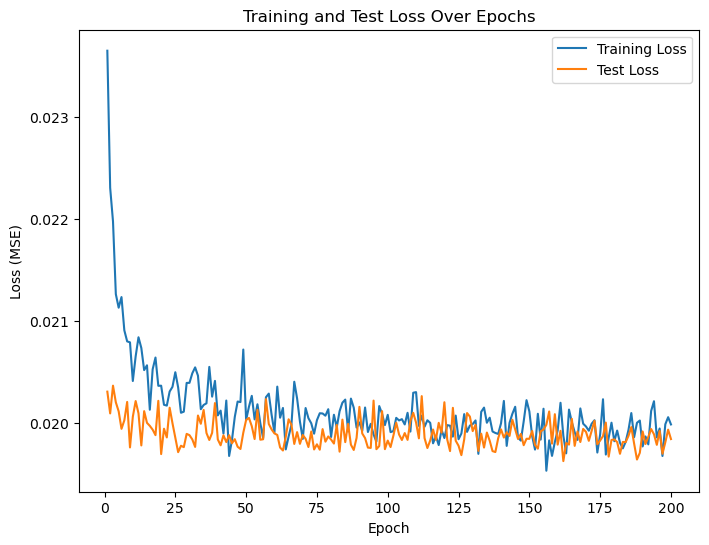

In [50]:
epochs = range(1, num_epochs+1)  # This will be range(1, 3) in your case

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_mse_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

In [68]:
loan_mapping = {'Small': 2, 'Medium': 1, 'Large': 0}
income_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
# education_mapping = {'High School': 0, 'Bachelor': 1, 'Master': 2}
# Zip_mapping = {'Rural': 0, 'Suburban': 1, 'Urban': 2}


In [70]:
inv_loan_mapping = {v: k for k, v in loan_mapping.items()}
inv_income_mapping = {v: k for k, v in income_mapping.items()}
# inv_education_mapping = {v: k for k, v in education_mapping.items()}
# inv_Zip_mapping = {v: k for k, v in Zip_mapping.items()}

In [72]:

X_test_df = pd.DataFrame(X_test, columns=features)

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level
0,1,0,2,1,1
1,2,1,0,1,1
2,1,0,2,1,0
3,0,2,0,2,2
4,1,2,1,0,1
...,...,...,...,...,...
3995,0,0,1,2,2
3996,1,2,1,2,0
3997,0,2,1,0,1
3998,1,1,0,2,0


In [74]:
X_test_df['Loan_Amount'] = X_test_df['Loan_Amount'].map(inv_loan_mapping)
X_test_df['Income_Level'] = X_test_df['Income_Level'].map(inv_income_mapping)
# X_test_df['Education_Level'] = X_test_df['Education_Level'].map(inv_education_mapping)
# X_test_df['Zip_Code'] = X_test_df['Zip_Code'].map(inv_Zip_mapping)

In [76]:
X_test_df

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level
0,1,Low,Small,1,0
1,2,Medium,Large,1,0
2,1,Low,Small,1,1
3,0,High,Large,2,2
4,1,High,Medium,0,0
...,...,...,...,...,...
3995,0,Low,Medium,2,2
3996,1,High,Medium,2,1
3997,0,High,Medium,0,0
3998,1,Medium,Large,2,1


In [78]:
credit_inverse_mapping = {0: 'bad', 1: 'fair', 2: 'good'}
Zip_Code_inverse_mapping = {0: 'Rural', 1: 'Suburban', 2: 'Urban'}
Education_Level_inverse_mapping = {0: 'Bachelor', 1: 'Highschool', 2: 'Master'}

In [80]:
X_test_df['Credit_History'] = X_test_df['Credit_History'].map(credit_inverse_mapping)

In [82]:
X_test_df['Zip_Code'] = X_test_df['Zip_Code'].map(Zip_Code_inverse_mapping)



In [84]:
X_test_df['Education_Level'] = X_test_df['Education_Level'].map(Education_Level_inverse_mapping)

In [86]:
X_test_df

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level
0,fair,Low,Small,Suburban,Bachelor
1,good,Medium,Large,Suburban,Bachelor
2,fair,Low,Small,Suburban,Highschool
3,bad,High,Large,Urban,Master
4,fair,High,Medium,Rural,Bachelor
...,...,...,...,...,...
3995,bad,Low,Medium,Urban,Master
3996,fair,High,Medium,Urban,Highschool
3997,bad,High,Medium,Rural,Bachelor
3998,fair,Medium,Large,Urban,Highschool


In [88]:
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()



In [90]:
# Build a DataFrame with the test inputs and the corresponding predictions.
df_test_predictions = pd.DataFrame(X_test_df, columns=features)
df_test_predictions['Prediction'] = predictions
print("\nTest Data with Predictions:")
print(df_test_predictions.head())


Test Data with Predictions:
  Credit_History Income_Level Loan_Amount  Zip_Code Education_Level  \
0           fair          Low       Small  Suburban        Bachelor   
1           good       Medium       Large  Suburban        Bachelor   
2           fair          Low       Small  Suburban      Highschool   
3            bad         High       Large     Urban          Master   
4           fair         High      Medium     Rural        Bachelor   

   Prediction  
0    0.541367  
1    0.507705  
2    0.541367  
3    0.356461  
4    0.595311  


In [92]:
df_test_predictions

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Prediction
0,fair,Low,Small,Suburban,Bachelor,0.541367
1,good,Medium,Large,Suburban,Bachelor,0.507705
2,fair,Low,Small,Suburban,Highschool,0.541367
3,bad,High,Large,Urban,Master,0.356461
4,fair,High,Medium,Rural,Bachelor,0.595311
...,...,...,...,...,...,...
3995,bad,Low,Medium,Urban,Master,0.313325
3996,fair,High,Medium,Urban,Highschool,0.626483
3997,bad,High,Medium,Rural,Bachelor,0.467131
3998,fair,Medium,Large,Urban,Highschool,0.369495


In [83]:
# df_test_predictions.to_csv("Statistical Test Dataset.csv")

In [94]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

In [96]:
def one_way_anova_with_eta(df, feature, target="Prediction"):

    # 1) Build formula like: "Prediction ~ C(feature)"
    formula = f"{target} ~ C({feature})"
    
    # 2) Fit ordinary least squares (OLS) model
    model = ols(formula, data=df).fit()
    
    # 3) Perform ANOVA
    anova_table = anova_lm(model, typ=2)

    sum_sq_factor = anova_table.loc[f"C({feature})", "sum_sq"]
    sum_sq_total = anova_table["sum_sq"].sum()  # factor + residual
    F_stat = anova_table.loc[f"C({feature})", "F"]
    p_value = anova_table.loc[f"C({feature})", "PR(>F)"]
    
    # Eta-squared = sum_sq_factor / sum_sq_total
    eta_sq = sum_sq_factor / sum_sq_total if sum_sq_total > 0 else 0.0
    
    return F_stat, p_value, eta_sq

In [98]:
features = ["Credit_History", "Income_Level", 
            "Loan_Amount", "Zip_Code", "Education_Level"]


In [100]:
results = []
for feat in features:
    F, pval, eta_sq = one_way_anova_with_eta(df_test_predictions, feat, target="Prediction")
    results.append({
        "Feature": feat,
        "F_stat": F,
        "Eta_squared": eta_sq,
        "p_val": pval
    })


In [102]:
results_df = pd.DataFrame(results)

In [104]:
results_df

,Feature,F_stat,Eta_squared,p_val
0,Credit_History,903.430382,0.311320,0.000000e+00
1,Income_Level,534.103227,0.210891,2.680945e-206
2,Loan_Amount,1460.483210,0.422229,0.000000e+00
3,Zip_Code,3.834810,0.001915,2.168497e-02
4,Education_Level,6.796269,0.003389,1.130902e-03


In [106]:
results_df.sort_values("Eta_squared", ascending=False, inplace=True)

In [108]:
print("\n=== One-Way ANOVA Results ===")
print(results_df.to_string(index=False))


=== One-Way ANOVA Results ===
        Feature      F_stat  Eta_squared         p_val
    Loan_Amount 1460.483210     0.422229  0.000000e+00
 Credit_History  903.430382     0.311320  0.000000e+00
   Income_Level  534.103227     0.210891 2.680945e-206
Education_Level    6.796269     0.003389  1.130902e-03
       Zip_Code    3.834810     0.001915  2.168497e-02


In [110]:
print("\nRanked Features by Eta-squared (descending):")
for i, row in results_df.iterrows():
    print(f"{row['Feature']}: Eta^2={row['Eta_squared']:.4f}")


Ranked Features by Eta-squared (descending):
Loan_Amount: Eta^2=0.4222
Credit_History: Eta^2=0.3113
Income_Level: Eta^2=0.2109
Education_Level: Eta^2=0.0034
Zip_Code: Eta^2=0.0019


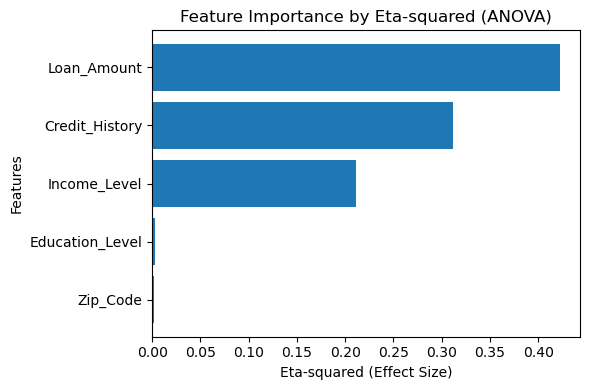

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))  # optional: adjust figure size

# Horizontal bar chart: barh(y, width)
plt.barh(results_df["Feature"], results_df["Eta_squared"])

# Because we sorted ascending, let's invert the y-axis
# so the largest effect size is at the top:
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("Eta-squared (Effect Size)")
plt.ylabel("Features")
plt.title("Feature Importance by Eta-squared (ANOVA)")

# Make layout neat
plt.tight_layout()

# Show the plot
plt.show()

In [114]:
def multiway_anova_with_eta(df, features, target="Prediction"):
    # Create formula: 'Prediction ~ C(f1) + C(f2) + ...'
    formula = f"{target} ~ " + " + ".join([f"C({f})" for f in features])
    
    # Fit OLS model
    model = smf.ols(formula, data=df).fit()
    
    # Run ANOVA
    anova_table = anova_lm(model, typ=2)

    # Total SS = sum of all SS including residual
    ss_total = anova_table["sum_sq"].sum()
    
    # Compute eta squared for each feature (excluding residual)
    eta_squared = (anova_table.loc[anova_table.index != "Residual", "sum_sq"] / ss_total).to_dict()
    
    # Combine with F and p-values
    results = {}
    for idx in anova_table.index:
        if idx == "Residual":
            continue
        results[idx.replace("C(", "").replace(")", "")] = {
            "F": anova_table.loc[idx, "F"],
            "p-value": anova_table.loc[idx, "PR(>F)"],
            "eta_squared": eta_squared[idx]
        }

    # Convert to DataFrame and rank
    df_results = pd.DataFrame(results).T
    df_results["rank"] = df_results["eta_squared"].rank(ascending=False)
    df_results = df_results.sort_values(by="eta_squared", ascending=False)
    
    return df_results

In [116]:
result = multiway_anova_with_eta(df_test_predictions, features)
print(result)

                            F   p-value  eta_squared  rank
Loan_Amount      58419.830633  0.000000     0.434398   1.0
Credit_History   44058.568675  0.000000     0.327610   2.0
Income_Level     29997.145742  0.000000     0.223053   3.0
Education_Level     11.757807  0.000008     0.000087   4.0
Zip_Code             2.882445  0.056114     0.000021   5.0


In [118]:
result

,F,p-value,eta_squared,rank
Loan_Amount,58419.830633,0.000000,0.434398,1.0
Credit_History,44058.568675,0.000000,0.327610,2.0
Income_Level,29997.145742,0.000000,0.223053,3.0
Education_Level,11.757807,0.000008,0.000087,4.0
Zip_Code,2.882445,0.056114,0.000021,5.0


In [120]:
def plot_effect_sizes(df_results):
    plt.figure(figsize=(8, 5))
    df_results = df_results.sort_values(by="eta_squared", ascending=True)  # for clean horizontal bars
    plt.barh(df_results.index, df_results["eta_squared"])
    plt.xlabel("Effect Size (Eta Squared)")
    plt.title("Feature Importance Based on ANOVA Effect Size")
    for i, v in enumerate(df_results["eta_squared"]):
        plt.text(v + 0.005, i, f"{v:.3f}", va='center')
    plt.tight_layout()
    plt.show()

# Call this after computing df_results
plot_effect_sizes(df_results)

NameError: name 'df_results' is not defined

In [122]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
        "Education_Level"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI       0.75     1.0 0.25            1


In [79]:
X_test_df

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level
0,1,0,2,1,0
1,2,1,0,1,0
2,1,0,2,1,1
3,0,2,0,2,2
4,1,2,1,0,0
...,...,...,...,...,...
3995,0,0,1,2,2
3996,1,2,1,2,1
3997,0,2,1,0,0
3998,1,1,0,2,1


In [235]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [233]:
def predict_proba_np(x_np):
    """
    x_np: np.array of shape (batch, 5), dtype int
    returns: np.array of shape (batch,) with predicted positive‐class probabilities
    """
    model.eval()
    with torch.no_grad():
        tensor = torch.LongTensor(x_np).to(device)
        logits = model(tensor)
        probs  = torch.sigmoid(logits).cpu().numpy().flatten()
    return probs


In [237]:
bg_size    = 100
bg_idx     = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[bg_idx] 

In [239]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [241]:
explainer = shap.KernelExplainer(predict_proba_np, background)


In [243]:
batch_size = 512
all_shap   = []

In [245]:
for start in range(0, len(X_test), batch_size):
    end    = min(start + batch_size, len(X_test))
    Xb_np  = X_test[start:end]
    
    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM {mem.available/1e9:.2f} GB")
    
    # nsamples controls speed/accuracy
    shap_vals_batch = explainer.shap_values(Xb_np, nsamples=100)
    all_shap.append(shap_vals_batch)

Batch 0-512: free RAM 3.03 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM 3.23 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM 3.00 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM 3.12 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM 3.14 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3072: free RAM 3.07 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 3072-3584: free RAM 3.20 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 3584-4000: free RAM 3.11 GB


  0%|          | 0/416 [00:00<?, ?it/s]

In [247]:
all_shap_values = np.vstack(all_shap)

In [249]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=features
).sort_values()

In [251]:
mean_abs   

Zip_Code           0.000395
Education_Level    0.000704
Income_Level       0.014792
Credit_History     0.017566
Loan_Amount        0.018405
dtype: float64

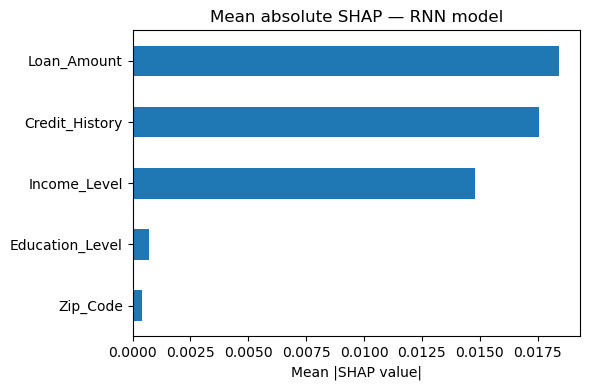

In [253]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — RNN model")
plt.tight_layout()
plt.savefig("shap/MLP_categorical_continous_shap_summary.jpg", dpi=300)
plt.show()

In [257]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
        "Education_Level",
        "Zip_Code"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        0.6     1.0  0.4            1
